# Aperture photometry of a moving object
This code performes aperture photomery of an asteroid.

In [1]:
import numpy as np
import numpy.ma as ma
import math
from scipy import *
from scipy import optimize
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, SkyCircularAperture
from photutils.detection import DAOStarFinder
from astroquery.mast import Catalogs
from astroquery.mpc import MPC
from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import mad_std
from astropy.io import ascii
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
file = 'rings.v3.skycell.0751.059.wrp.r.56290_57022.fits'

In [4]:
# Defining the variables
stars_mag_min = 17.5  # min brightness of a reference star
stars_mag_max = 15.5  # max brightness of a reference stara
target = '2012 DR30'  # name of an object
stars_search_radius = 0.15 # search radius in arcmin

In [5]:
obj_sub_size = 15         # Size of a subimage with a target
star_sum_size = 15        # Size of a subimage with a star

In [6]:
# Transforming image coordinates to WCS
hdulist = fits.open(file)
wcs = WCS(hdulist[1].header)
im = hdulist[1].data
im = np.where(np.isnan(im), ma.array(im, mask=np.isnan(im)).mean(), im) #replacing NaN values with a mean value across an image

In [7]:
# Selecting only stars with known magnitides in corresponding filters (grizy) and giving a number to each filter
im_filter = hdulist[1].header['FPA.FILTERID'][0]
if im_filter == 'g':
    number = 3
elif im_filter == 'r':
    number = 4
elif im_filter == 'i':
    number = 5
elif im_filter == 'z':
    number = 6
else:
    number = 7

number_err = number + 5 # Number for the corresponding mag error

In [8]:
#Searching for a moving object (our target) in the image using ephemerides from the MPC.
MJD0 = hdulist[1].header['MJD-OBS'] # MJD from the header
MJD = Time(MJD0, format='mjd') # Setting the format to the date
eph = MPC.get_ephemeris(target, start=MJD, number=1) # ephemerides
ra_obj = eph['RA']
dec_obj = eph['Dec']
coords_obj  = str(float(ra_obj)) + ' ' + str(float(dec_obj))

date_obs = str(eph['Date'])
r_dist = float(eph['r'])
delta = float(eph['Delta'])
phang = float(eph['Phase'])

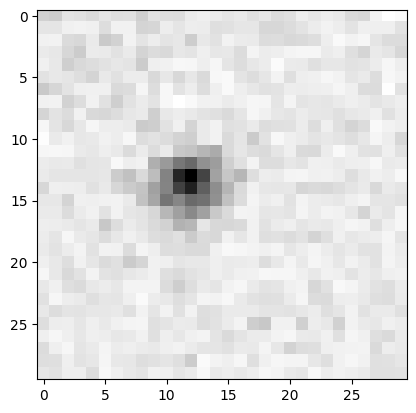

In [9]:
# Finding the target on the image
py_obj, px_obj = wcs.wcs_world2pix(ra_obj, dec_obj, 1)
coord_obj = [int(px_obj), int(py_obj)]

x_obj = coord_obj[0]
y_obj = coord_obj[1]
sub_obj = im[x_obj-obj_sub_size:x_obj+obj_sub_size,y_obj-obj_sub_size:y_obj+obj_sub_size]
plt.imshow(sub_obj, cmap='Greys')
plt.show()

In [10]:
# Finding point sourses in the subimages of stars
def findPSF(sub,fwhm,threshold):
    sub -= np.median(sub) 
    bkg_sigma = mad_std(sub)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*bkg_sigma)  
    psf = daofind(sub) # Centroid of the found object
    return psf

def gauss(sky, ampl, width_x, width_y):
    return lambda x,y: sky + ampl*exp(-(((x_cen-x)/width_x)**2+((y_cen-y)/width_y)**2)/2)

def findFWHM(sub):
    params = [1.,40.,3.,3.]
    errorfunction = lambda p: ravel(gauss(*p)(*indices(sub.shape)) - sub)
    p, success = optimize.leastsq(errorfunction, params)
    width_x = abs(p[2])
    width_y = abs(p[3])
    fwhm_star = 2.0*math.sqrt(2.0*math.log(2.0))*math.sqrt(width_x**2 + width_y**2)
    return fwhm_star

In [11]:
coords_phot = []
moving_target = findPSF(sub_obj, 8., 5)
print(moving_target)

 id     xcentroid     ...        flux               mag        
--- ----------------- ... ----------------- -------------------
  1 11.79852697690449 ... 5.137918472290039 -1.7769680216653116


In [12]:
y_cen = float(moving_target['xcentroid'])
x_cen = float(moving_target['ycentroid'])

global_coord_obj_x = px_obj + (x_cen - obj_sub_size)
global_coord_obj_y = py_obj + (y_cen - obj_sub_size)
global_coord_obj = [float(global_coord_obj_x), float(global_coord_obj_y)]
coords_phot.append(global_coord_obj)

In [13]:
# Searching for the comparison stars in PanStarrs catalog
cat_data = Catalogs.query_region(coords_obj, catalog="PanSTARRS", objType="STAR", radius=stars_search_radius)
print(len(cat_data), ' stars found in PanSTARRS')

18056  stars found in PanSTARRS


In [14]:
# Sorting the found stars by magnitude
mag = cat_data['rMeanPSFMag']
Sorted_stars = [] 

for j in range(len(cat_data)):
    if mag[j] < stars_mag_min and mag[j] > stars_mag_max:
        Name = cat_data['objName']
        RA_star = cat_data['raMean']
        DEC_star = cat_data['decMean']

        g_mag = cat_data['gMeanPSFMag']
        r_mag = cat_data['rMeanPSFMag']
        i_mag = cat_data['iMeanPSFMag']
        z_mag = cat_data['zMeanPSFMag']
        y_mag = cat_data['yMeanPSFMag']

        g_mag_err = cat_data['gMeanPSFMagErr']
        r_mag_err = cat_data['rMeanPSFMagErr']
        i_mag_err = cat_data['iMeanPSFMagErr']
        z_mag_err = cat_data['zMeanPSFMagErr']
        y_mag_err = cat_data['yMeanPSFMagErr']

        a = [Name[j], RA_star[j], DEC_star[j], g_mag[j], r_mag[j], i_mag[j], z_mag[j],y_mag[j], g_mag_err[j], r_mag_err[j], i_mag_err[j], z_mag_err[j],y_mag_err[j]]
        Sorted_stars.append(a)
    else:
        pass
print(len(Sorted_stars), ' stars left after sorting by magnitude')

111  stars left after sorting by magnitude


In [15]:
# Selecting stars with solar-like colors
Sorted_stars_colors = []
# Sun colors g-r=0.44+/-0.02; r-i=0.11+/-0.02; i-z=0.03+/-0.02
for star in Sorted_stars:
    if 0.24 < star[3] - star[4] < 0.64: # g-r color
       Sorted_stars_colors.append(star)

print(len(Sorted_stars_colors), ' left after sorting by colors')

48  left after sorting by colors


In [16]:
# Selecting stars with known manitude
Sorted_stars_again = [] 
for star in Sorted_stars_colors:
    if len(str(star[number])) > 2:
        Sorted_stars_again.append(star)

print(len(Sorted_stars_again), ' stars left after removing those with unknown magnitudes')

48  stars left after removing those with unknown magnitudes


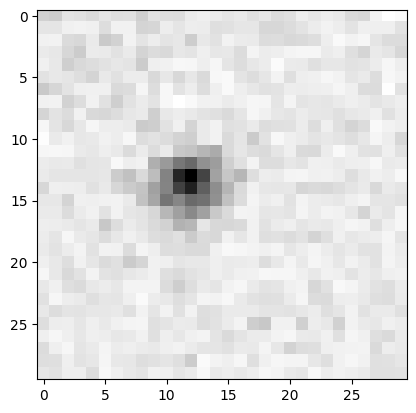

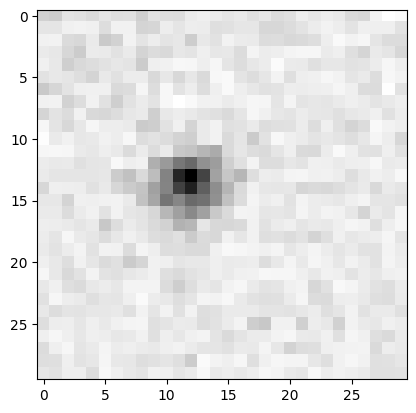

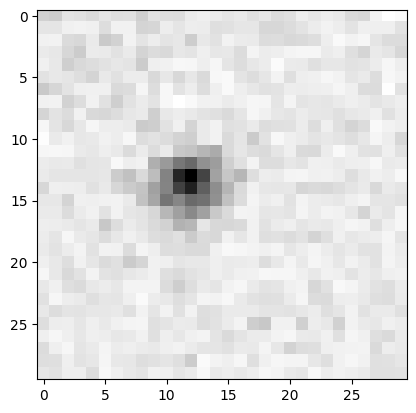

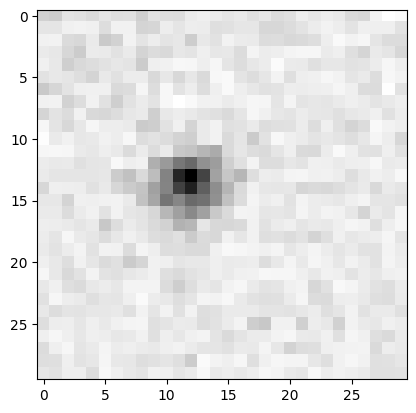

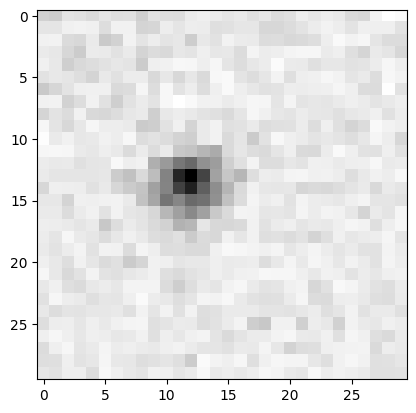

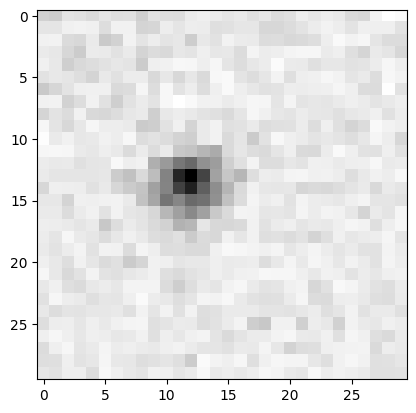

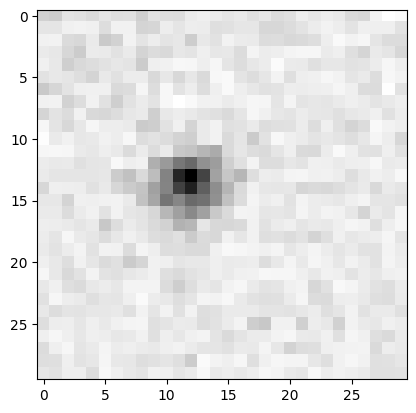

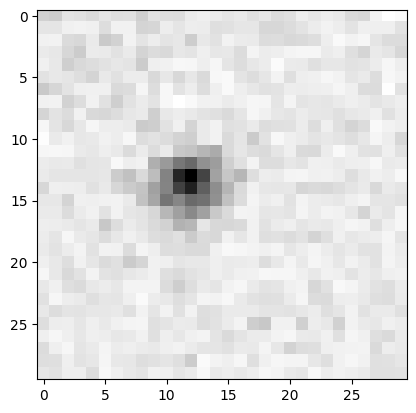

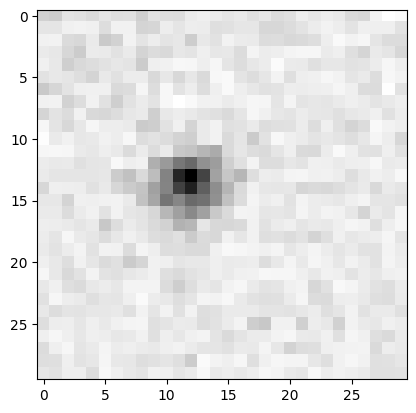

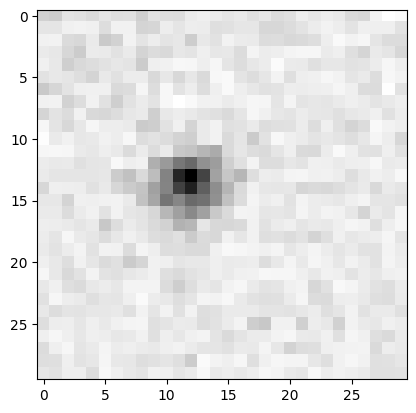

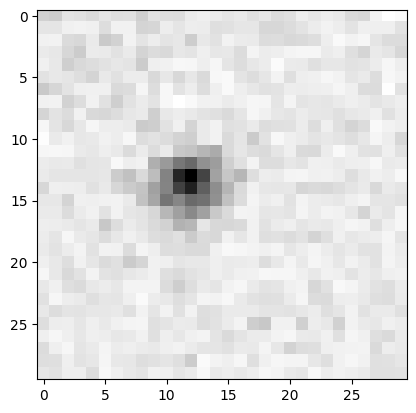

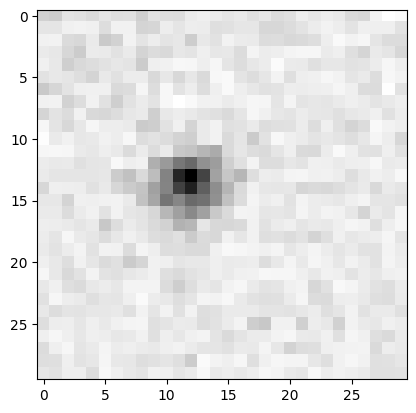

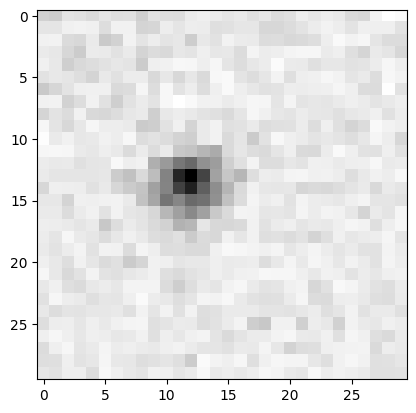

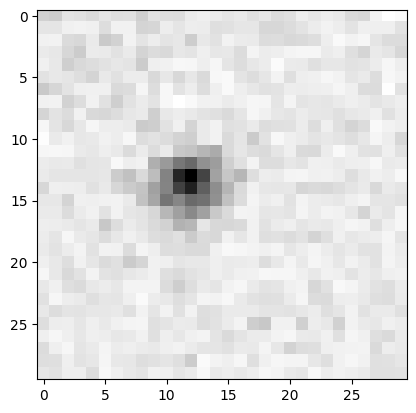

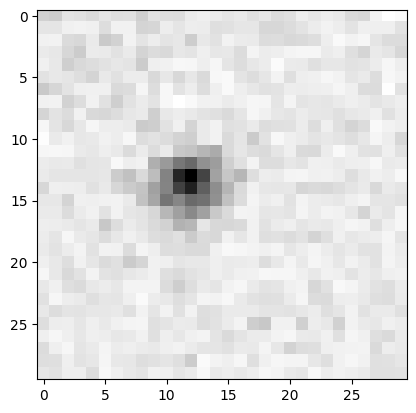

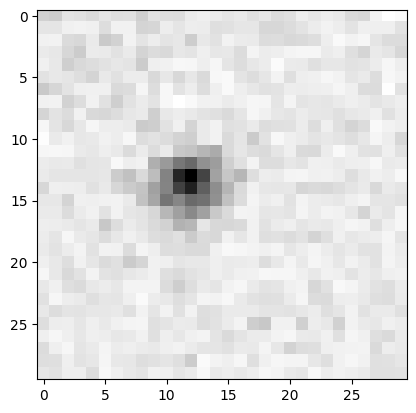

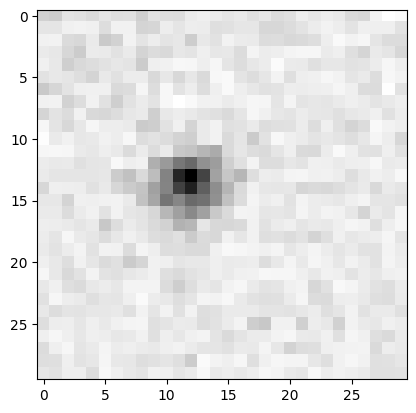

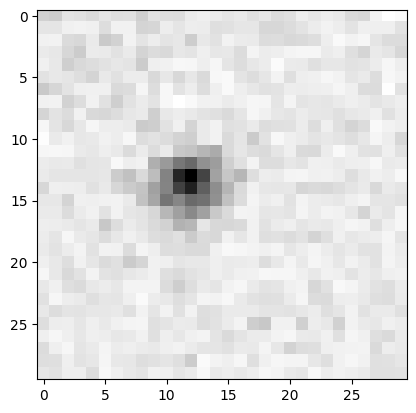

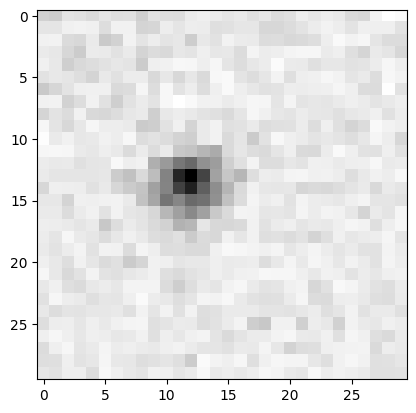

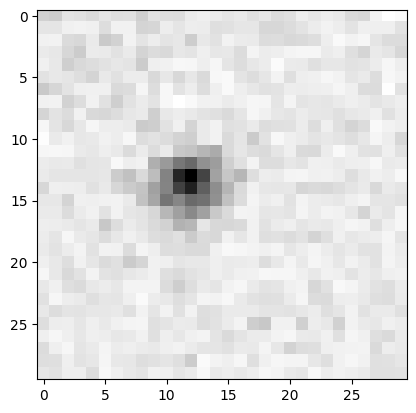

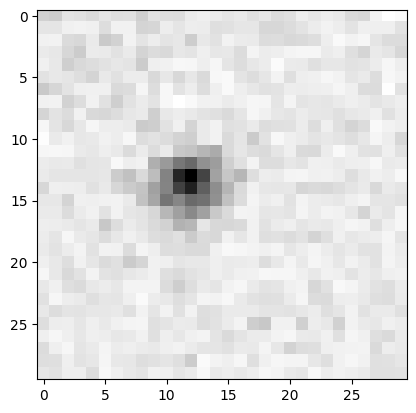

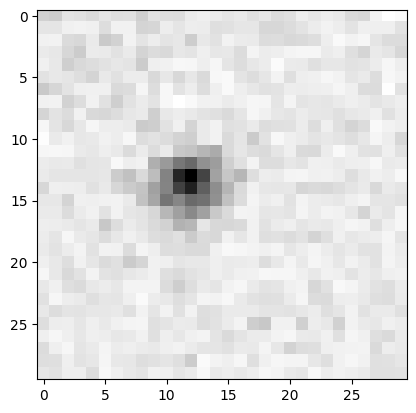

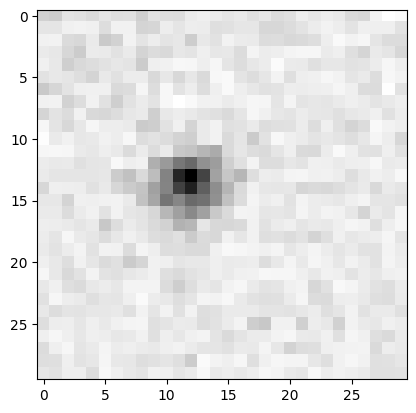

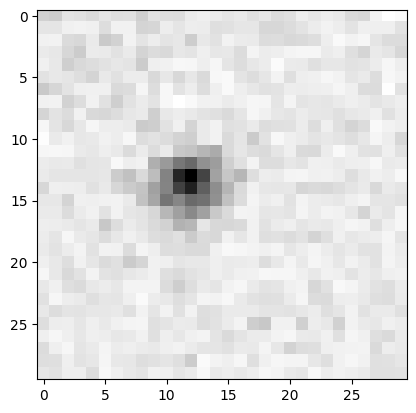

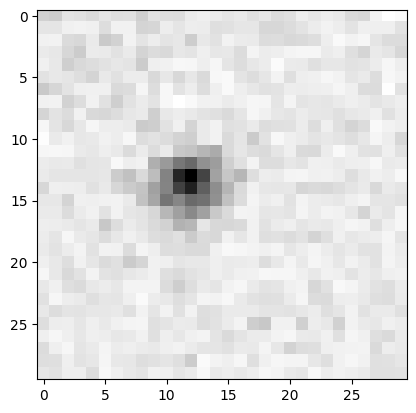

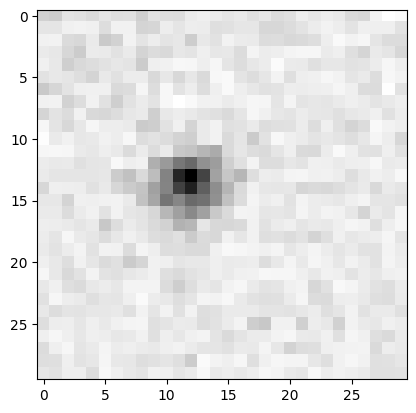

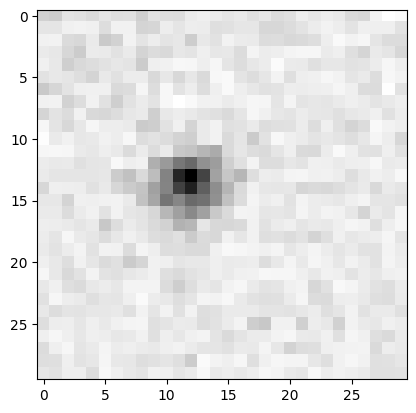

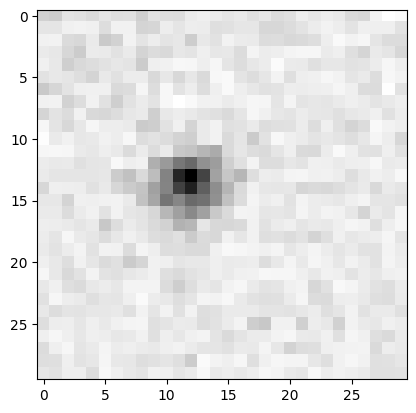

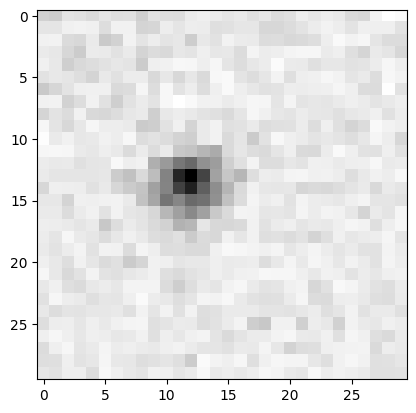

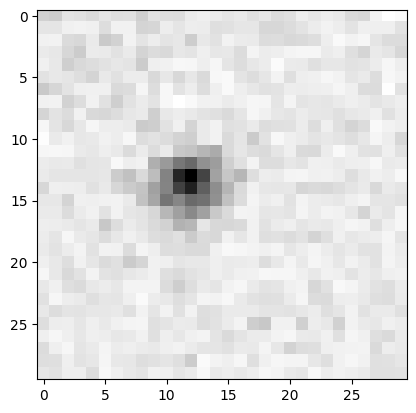

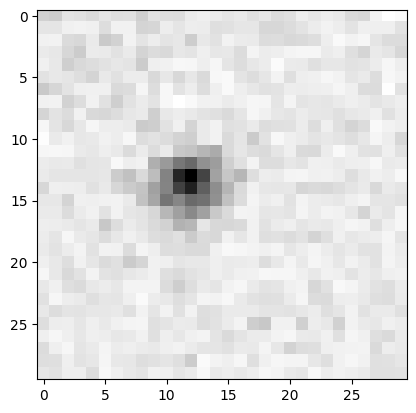

31  stars found in the image


In [17]:
Sorted_stars_again_and_again = []
FWHM = []
for star in Sorted_stars_again:
    star_ra, star_dec = star[1], star[2]

    py_star, px_star = wcs.wcs_world2pix(star_ra, star_dec, 1)
    if 0 < px_star < np.shape(im)[0] or 0 < py_star < np.shape(im)[1]: # If a star is in the image
        coord_star = [int(px_star), int(py_star)]
        x_star = coord_star[0]
        y_star = coord_star[1]
        sub_star = im[x_star-star_sum_size:x_star+star_sum_size,y_star-star_sum_size:y_star+star_sum_size]
        source = findPSF(sub_star,6,10)

        if source is not None and len(source) == 1: #If one star objest is found in the subimage

            fwhm_star = findFWHM(sub_star)
            FWHM.append(fwhm_star)

            Sorted_stars_again_and_again.append(star) 
            x_cen = float(source['xcentroid'])  # coordinates in the sub image
            y_cen = float(source['ycentroid'])
            global_coord_x = px_star + (y_cen - star_sum_size) # precise coordinates in the image
            global_coord_y = py_star + (x_cen - star_sum_size)
            global_coord = [global_coord_x, global_coord_y]
            coords_phot.append(global_coord)
            plt.imshow(sub_obj, cmap='Greys')
            plt.show()
        else:
            pass
    else:
        pass

print(len(Sorted_stars_again_and_again), ' stars found in the image')

In [18]:
#Mean FWHM from selected final stars
FWHM_std = np.std(FWHM)
FWHM_sorted = []

for value in FWHM:
    if value < 20:
       FWHM_sorted.append(value) 

FWHM = np.average(FWHM_sorted)
print('Mean FWHM value for this image is ', round(FWHM,1))

Mean FWHM value for this image is  6.8


In [19]:
x_phot = []
y_phot = []
for i in coords_phot:
    x_phot.append(i[1])
    y_phot.append(i[0])

aper_rad = FWHM*0.9
aper_sky = aper_rad*1.6

In [20]:
# Performing aperture photometry
positions = np.transpose((x_phot, y_phot))                                     #Coordinates of the object (first) and the stars
aperture = CircularAperture(positions, r=aper_rad)                               #Objects
annulus_aperture = CircularAnnulus(positions, r_in=aper_sky, r_out=aper_sky + 7)  #Local sky in the circle
apers = [aperture, annulus_aperture]                                              #Both

phot_table = aperture_photometry(im, apers)
print(phot_table)

 id      xcenter            ycenter         aperture_sum_0      aperture_sum_1  
           pix                pix                                               
--- ------------------ ------------------ ------------------ -------------------
  1  4154.994278354668 3942.1680083698366  6116.037554577522   384.6178916031222
  2  4266.504365599961  3072.237335369533  93717.07797722876  -4360.086820128129
  3  5569.342307970149  5094.004517097078 30227.291580498488 -1806.9746951857023
  4  2832.084724983227 3052.6719338047897  58869.34514008328   -5051.46843375871
  5 2583.9287520045523  3112.669479409573 114866.97144634064  -4704.488907579408
  6   3386.93707658839  2143.086507448588 132171.82650688686  -5284.703708337859
  7 2617.2558027774826   3584.87314038269  42655.43576243862   -4240.32258830741
  8  2422.594355830345   3335.25437480638 138964.06838012527  -5560.648376558891
  9  4573.211128362131  3630.798843437725 101373.45817305475  -5228.359095044089
 10  5387.374656128877  3130

In [21]:
# One object (only to have a different aperture color for a target object)
posit_obj = np.transpose((x_phot[0], y_phot[0])) 
aper_obj = CircularAperture(posit_obj, r=aper_rad)                 
annulus_aper_obj = CircularAnnulus(posit_obj, r_in=aper_sky, r_out=aper_sky + 7)

In [22]:
# Removing background signal
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_sum = bkg_mean * aperture.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum

In [23]:
# Calculating SNR and uncertanties
SNR = []
exp = hdulist[1].header['EXPTIME']

In [24]:
#intensity = phot_table['residual_aperture_sum']
for j in phot_table['residual_aperture_sum']:
    if math.isnan(j) == False and j > 0:
        snr = round(math.sqrt(j/exp),0)
    else:
        snr = 0
    #err = 1.086/SNR
    SNR.append(snr)

phot_table['SNR'] = SNR

In [25]:
# Normalising intersity to unity (1sec exptime) 
unity_intensity = phot_table['residual_aperture_sum']/exp
phot_table['unity_intensity'] = unity_intensity

In [26]:
# for consistent table output
phot_table['xcenter'].info.format = '%.7g'    
phot_table['ycenter'].info.format = '%.7g'
phot_table['aperture_sum_0'].info.format = '%.8g'
phot_table['aperture_sum_1'].info.format = '%.6g'
phot_table['residual_aperture_sum'].info.format = '%.8g'
phot_table['residual_aperture_sum'].info.format = '%.8g'
phot_table['SNR'].info.format = '%g'
phot_table['unity_intensity'].info.format = '%.7g'

In [27]:
# Photometry result table
print(phot_table)

 id xcenter  ycenter  ... residual_aperture_sum SNR unity_intensity
      pix      pix    ...                                          
--- -------- -------- ... --------------------- --- ---------------
  1 4154.994 3942.168 ...             6038.1204  12         150.953
  2 4266.504 3072.237 ...             94600.359  49        2365.009
  3 5569.342 5094.005 ...             30593.355  28        764.8339
  4 2832.085 3052.672 ...             59892.689  39        1497.317
  5 2583.929 3112.669 ...             115820.02  54        2895.501
  6 3386.937 2143.087 ...             133242.42  58         3331.06
  7 2617.256 3584.873 ...             43514.455  33        1087.861
  8 2422.594 3335.254 ...             140090.56  59        3502.264
  9 4573.211 3630.799 ...             102432.64  51        2560.816
 10 5387.375 3130.291 ...             79708.909  45        1992.723
...      ...      ... ...                   ... ...             ...
 23 4079.834 5876.879 ...             28919.005 

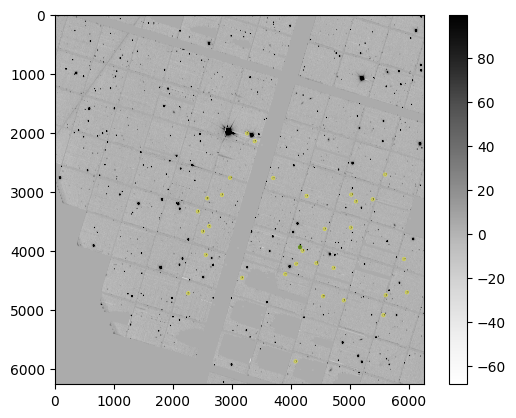

In [28]:
# Plotting the image with apertures around the target and the selected stars
interval  = ZScaleInterval()
vmin,vmax = interval.get_limits(im)
plt.imshow(im, cmap='Greys', vmin=vmin,vmax=vmax)
aperture.plot(color='blue', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='yellow', lw=1.5, alpha=0.5)
aper_obj.plot(color='red', lw=1.5, alpha=0.5)
annulus_aper_obj.plot(color='green', lw=1.5, alpha=0.5)
plt.colorbar()
plt.show()

In [29]:
star_mag = ['--']
star_err = ['--']
for star in Sorted_stars_again_and_again:
    star_mag.append(round(star[number],3))
    star_err.append(round(star[number_err],3))

In [30]:
# Writing to files
to_file_res = [phot_table['xcenter'],phot_table['ycenter'],phot_table['SNR'],phot_table['unity_intensity'],star_mag, star_err]
names=['x', 'y', 'SNR', 'unity_intensity', 'star_mag', 'mag_err']

In [31]:
mags_str = 'g'+'\t'+'g_err'+'\t'+'r'+'\t'+'r_err'+'\t'+'i'+'\t'+ 'i_err'+'\t'+'z'+'\t'+'z_err'+'\t'+'y'+'\t'+ 'y_err'

In [32]:
stars_file = 'stars_list.dat'
with open(stars_file, 'a') as f:
    f.writelines(file + '\n' + '\n')
    f.writelines('Name' + '\t' +  'RA' + '\t' + 'DEC' + '\t' + str(mags_str) + '\n')
    for l in Sorted_stars_again_and_again:
        Name = str(l[0])
        #g,r,i,z,y = str(round(l[3],3)),str(round(l[4],3)),str(round(l[5],3)),str(round(l[6],3)),str(round(l[7],3))
        g,r,i,z,y = str(l[3]),str(l[4]),str(l[5]),str(l[6]),str(l[7])
        #g_err,r_err,i_err,z_err,y_err = str(round(l[8],3)),str(round(l[9],3)),str(round(l[10],3)),str(round(l[11],3)),str(round(l[12],3))
        g_err,r_err,i_err,z_err,y_err = str(l[8]),str(l[9]),str(l[10]),str(l[11]),str(l[12])
        mags_values = g +'\t'+ g_err +'\t'+ r +'\t'+ r_err +'\t'+ i +'\t'+ i_err +'\t'+ z +'\t'+ z_err +'\t'+ y +'\t'+ y_err
        f.writelines(Name +'\t'+ str(round(l[1],4))  +'\t'+ str(round(l[2],4)) +'\t'+ mags_values + '\n')
    f.writelines('\n' + '\n')

In [33]:
object_file = 'object_list.dat'
with open(object_file, 'a') as w:
    w.writelines(file + '\n')
    w.writelines('Date' +'\t'+  'r, AU' +'\t'+ 'Delta, AU' +'\t'+ 'Phase angle, deg' + '\n')
    w.writelines(date_obs +'\t'+ str(r_dist) +'\t'+ str(delta) +'\t'+ str(phang) + '\n')
    w.writelines('\n' + '\n')

In [34]:
outfile = file + '.dat'
ascii.write(to_file_res, outfile, names = names, overwrite=True)